In [30]:
import cv2
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import PIL
from PIL import Image
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from scipy.signal import find_peaks
from skimage.color import rgb2gray
from skimage import img_as_ubyte
from skimage.filters.rank import entropy as entropy_filter
from skimage.morphology import disk

In [2]:
PIL.Image.MAX_IMAGE_PIXELS = 2231040000  

In [3]:
background_datasets = ["/scratch/gpfs/RUSTOW/deskewing_datasets/images/texture_ninja", 
                       "/scratch/gpfs/RUSTOW/deskewing_datasets/images/pexels_textures",
                       "/scratch/gpfs/RUSTOW/deskewing_datasets/images/open_images_v7_validation"]
document_datasets = ["/scratch/gpfs/RUSTOW/deskewing_datasets/images/cudl_images/images",
                     "/scratch/gpfs/RUSTOW/deskewing_datasets/images/doc_lay_net",
                     "/scratch/gpfs/RUSTOW/deskewing_datasets/images/publaynet"]

In [4]:
def check_corruption(file_path):
    try:
        with Image.open(file_path):
            pass
        return None
    except Exception:
        return file_path

def find_corrupted_images(dataset):
    files = get_files_in_parent(dataset)
    corrupted_files = []

    with Pool(processes=cpu_count()) as pool:
        for corrupted_file in tqdm(pool.imap_unordered(check_corruption, files), total=len(files), desc=f"Checking {os.path.basename(dataset)}"):
            if corrupted_file:
                corrupted_files.append(corrupted_file)
                
    return corrupted_files

def delete_files(file_paths):
    for file_path in file_paths:
        try:
            os.remove(file_path)
            print(f"Deleted {file_path}")
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")

In [5]:
# all_corrupted_files = []

# for dataset in background_datasets + document_datasets:
#     corrupted_files = find_corrupted_images(dataset)
#     all_corrupted_files.extend(corrupted_files)

In [6]:
# delete_files(all_corrupted_files)

In [7]:
def get_files_in_parent(root):
    return glob.glob(os.path.join(root, "**", "*.*"), recursive=True)

In [8]:
def fetch_dimensions(file):
    try:
        with Image.open(file) as img:
            return img.size
    except Exception as e:
        print(f"Error with file {file}: {e}")
        return None


def get_image_dimensions(dataset_path):
    files = get_files_in_parent(dataset_path)
    with Pool(processes=cpu_count()) as pool:
        dimensions = list(tqdm(pool.imap(fetch_dimensions, files), total=len(files), desc=f"Processing {os.path.basename(dataset_path)}"))
    return [(w, h) for w, h in dimensions if w is not None and h is not None]


In [9]:
def plot_image_dimensions(dimensions, ax, title):
    widths, heights = zip(*dimensions)
    ax.scatter(widths, heights, alpha=0.6, edgecolors="w", linewidth=0.5)
    
    ax.set_title(title)
    ax.set_xlabel("Width")
    ax.set_ylabel("Height")
    ax.grid(True)


# fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# for idx, dataset in enumerate(background_datasets):
#     dimensions = get_image_dimensions(dataset)
#     plot_image_dimensions(dimensions, axes[0, idx], os.path.basename(dataset))

# for idx, dataset in enumerate(document_datasets):
#     dimensions = get_image_dimensions(dataset)
#     plot_image_dimensions(dimensions, axes[1, idx], os.path.basename(dataset))

# plt.tight_layout()
# plt.show()

In [10]:
def get_image_info(img, file_path):
    """Retrieve basic image details."""
    width, height = img.size
    aspect_ratio = width / height
    file_format = img.format
    file_size = os.path.getsize(file_path) 
    return width, height, aspect_ratio, file_format, file_size

def get_color_info(np_img):
    """Retrieve color-related metrics."""
    avg_colors = np_img.mean(axis=(0, 1)) if len(np_img.shape) == 3 else np_img.mean()
    intensity_variance = np_img.var()
    dominant_color = ["Red", "Green", "Blue"][np.argmax(avg_colors)] if len(np_img.shape) == 3 else None
    has_transparency = (np_img.shape[2] == 4) and (np_img[:, :, 3].min() < 255)
    return avg_colors, intensity_variance, dominant_color, has_transparency

def get_advanced_metrics(np_img_gray):
    """Retrieve histogram peaks and entropy."""
    hist, _ = np.histogram(np_img_gray, bins=256, range=(0, 256))
    peaks, _ = find_peaks(hist)
    num_peaks = len(peaks)
    
    local_entropies = entropy_filter(np_img_gray, disk(5))
    avg_entropy = local_entropies.mean()
    
    return num_peaks, avg_entropy

def image_eda(file_path):
    try:
        with Image.open(file_path) as img:
            # np_img = np.array(img)
            width, height, aspect_ratio, file_format, file_size = get_image_info(img, file_path)
#             avg_colors, intensity_variance, dominant_color, has_transparency = get_color_info(np_img)
#             np_img_gray = img_as_ubyte(rgb2gray(np_img))
#             num_peaks, avg_entropy = get_advanced_metrics(np_img_gray)

            return width, height, aspect_ratio, file_format, file_size#, avg_colors, intensity_variance, dominant_color, has_transparency, num_peaks, avg_entropy

    except Exception as e:
        print(e)
        return None


def aggregate_eda_data(dataset):
    files = get_files_in_parent(dataset)
    results = []

    with Pool(processes=cpu_count()) as pool:
        for result in tqdm(pool.imap_unordered(image_eda, files), total=len(files), desc=f"EDA for {os.path.basename(dataset)}"):
            if result:
                results.append(result)
                
    return results

In [11]:
eda_dataset = document_datasets[0]
eda_data = aggregate_eda_data(eda_dataset)

EDA for images: 100%|██████████| 854034/854034 [11:18<00:00, 1259.61it/s]


In [12]:
# Rename datasets for better clarity
datasets_mapping = {
    "/scratch/gpfs/RUSTOW/deskewing_datasets/images/texture_ninja": "Texture Ninja Backgrounds",
    "/scratch/gpfs/RUSTOW/deskewing_datasets/images/pexels_textures": "Pexels Backgrounds",
    "/scratch/gpfs/RUSTOW/deskewing_datasets/images/open_images_v7_validation": "Open Images V7 Backgrounds",
    "/scratch/gpfs/RUSTOW/deskewing_datasets/images/cudl_images/images": "CUDL Images",
    "/scratch/gpfs/RUSTOW/deskewing_datasets/images/doc_lay_net": "Doclaynet",
    "/scratch/gpfs/RUSTOW/deskewing_datasets/images/publaynet": "Publaynet"
}

In [21]:
def remove_invalid_values(data):
    return [value for value in data if value is not None and np.isfinite(value)]

In [28]:
def plot_histogram(ax, data, title, xlabel):
    """Utility function to plot a histogram on the given axes."""
    sns.histplot(data, bins=255, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Number of Images")
    ax.grid(True)
    ax.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis

def plot_violin(ax, data, title, xlabel):
    """Utility function to plot a violin plot on the given axes."""
    sns.violinplot(x=data, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.grid(True)

def plot_eda_data(eda_data, dataset_name):
    # Unpack EDA data
    widths, heights, aspect_ratios, _, file_sizes = zip(*eda_data)

    # Clean data
    clean_widths = remove_invalid_values(widths)
    clean_heights = remove_invalid_values(heights)
    clean_aspect_ratios = remove_invalid_values(aspect_ratios)
    clean_file_sizes = remove_invalid_values(file_sizes)

    # Setup 2x2 plot grid
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    # Plot on respective axes
    plot_histogram(axes[0, 0], clean_widths, f"Width Distribution for {dataset_name}", "Width (pixels)")
    plot_histogram(axes[0, 1], clean_heights, f"Height Distribution for {dataset_name}", "Height (pixels)")
    plot_violin(axes[1, 0], clean_aspect_ratios, f"Aspect Ratio Distribution for {dataset_name}", "Aspect Ratio")
    plot_histogram(axes[1, 1], clean_file_sizes, f"File Size Distribution for {dataset_name}", "File Size (bytes)")
    
    # Adjust layout for better appearance
    plt.tight_layout()
    plt.show()


    
# def plot_eda_data(eda_data, dataset_name):
#     # Unpack EDA data
#     # widths, heights, avg_colors, file_formats, file_sizes, aspect_ratios, intensity_variances, dominant_colors, _, num_peaks, avg_entropies = zip(*eda_data)

#     # Plot
#     plot_histogram(widths, f"Width Distribution for {dataset_name}", "Width (pixels)")
#     plot_histogram(heights, f"Height Distribution for {dataset_name}", "Height (pixels)")
#     plot_histogram(aspect_ratios, f"Aspect Ratio Distribution for {dataset_name}", "Aspect Ratio")
#     plot_histogram(file_sizes, f"File Size Distribution for {dataset_name}", "File Size (bytes)")
#     # plot_histogram(intensity_variances, f"Intensity Variance for {dataset_name}", "Intensity Variance")
#     # plot_histogram(num_peaks, f"Histogram Peaks for {dataset_name}", "Number of Peaks")
#     # plot_histogram(avg_entropies, f"Average Entropy for {dataset_name}", "Average Entropy")
    
#     # plt.figure(figsize=(10, 6))
#     # sns.countplot(x=dominant_colors)
#     # plt.title(f"Dominant Color Distribution for {dataset_name}")
#     # plt.xlabel("Dominant Color")
#     # plt.ylabel("Number of Images")
#     # plt.grid(axis="y")
#     # plt.show()
    
    

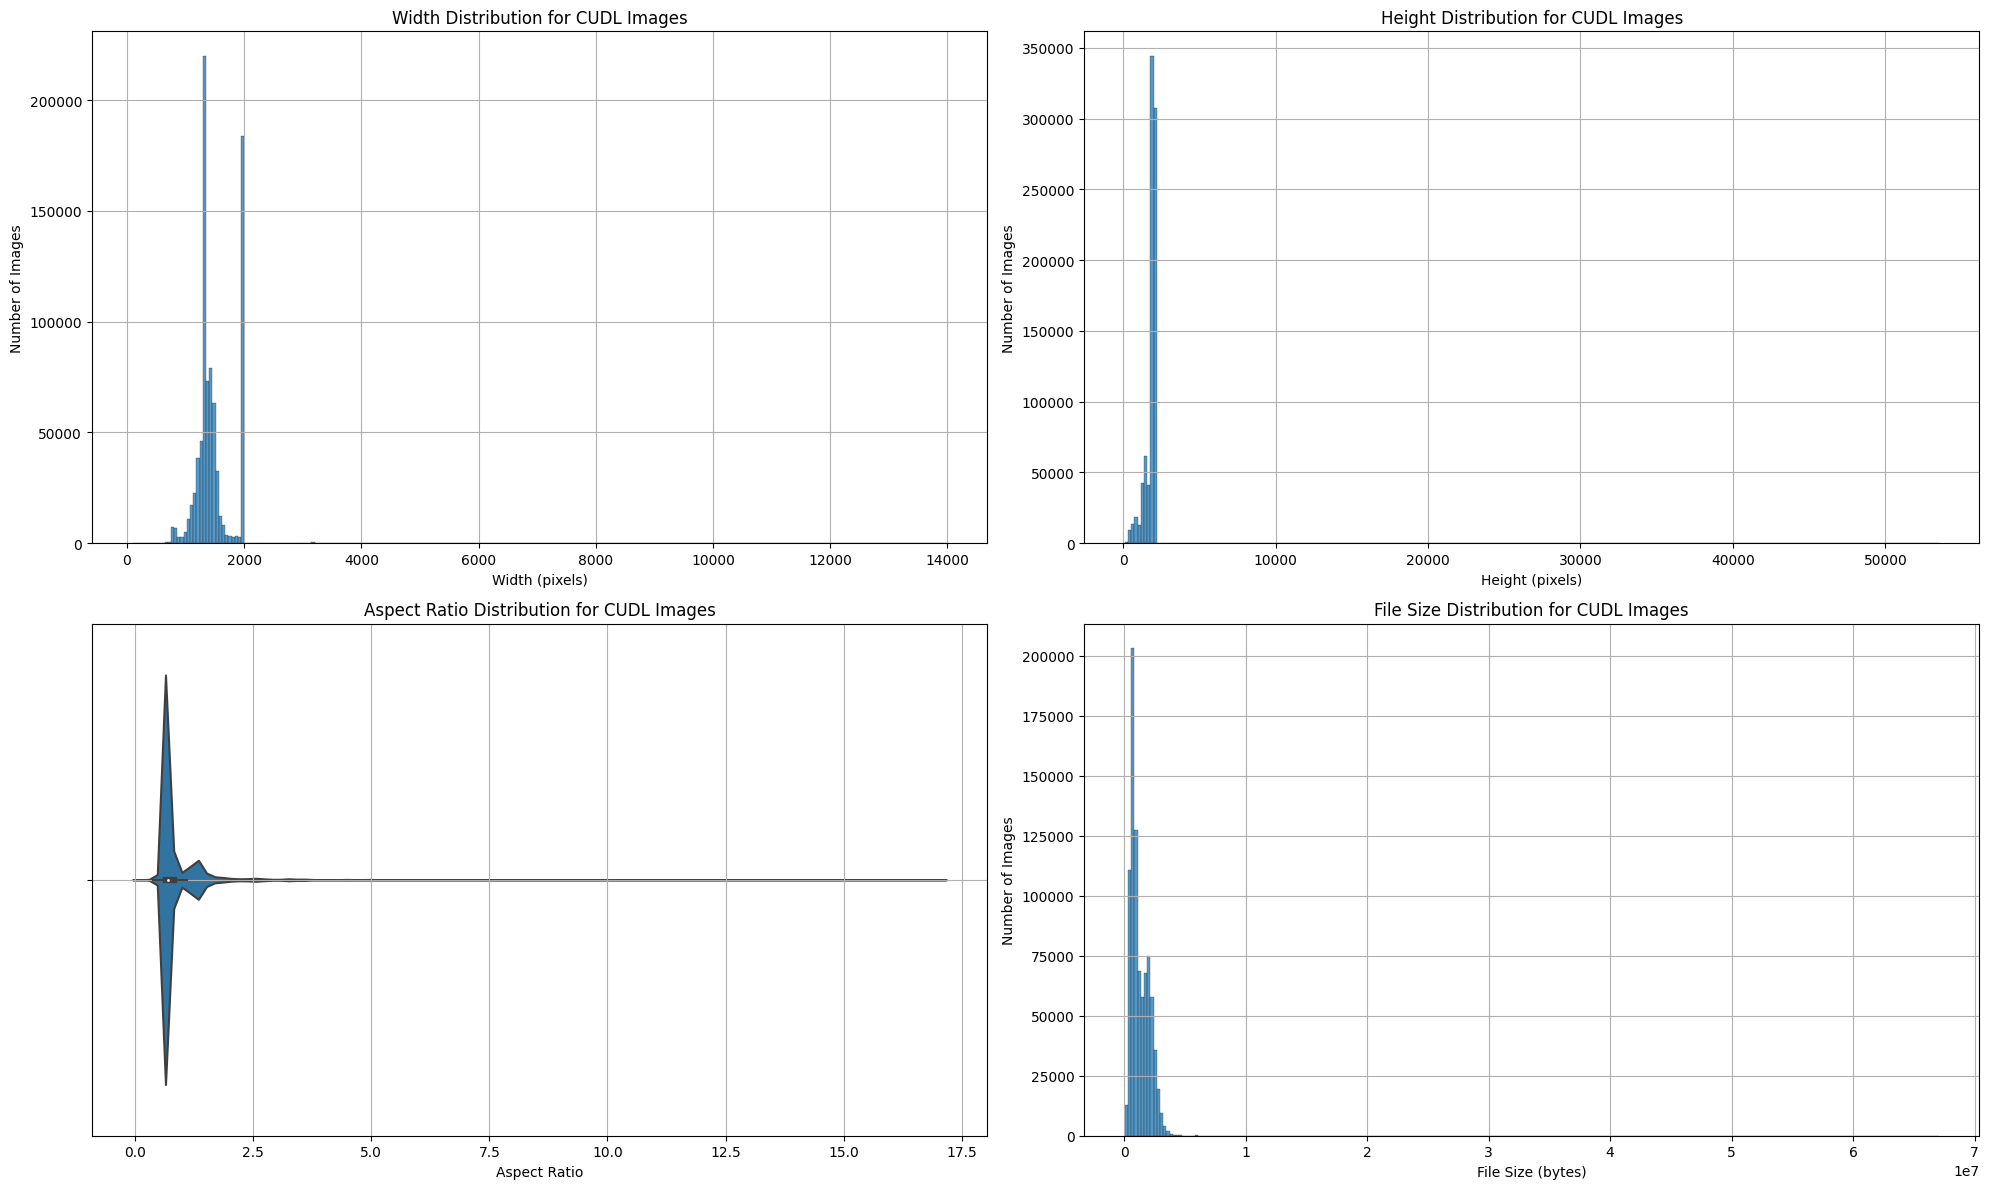

In [29]:
plot_eda_data(eda_data, datasets_mapping[eda_dataset])

In [34]:
def display_random_images(dataset_path, num_images=25):
    all_files = get_files_in_parent(dataset_path)
    
    selected_files = random.sample(all_files, min(num_images, len(all_files)))
    
    sqrt_num = int(np.sqrt(num_images))
    fig, axes = plt.subplots(sqrt_num, sqrt_num, figsize=(15, 15))
    
    for ax, img_path in zip(axes.ravel(), selected_files):
        with Image.open(img_path) as img:
            ax.imshow(img)
            ax.axis('off')
            
    plt.tight_layout()
    plt.show()

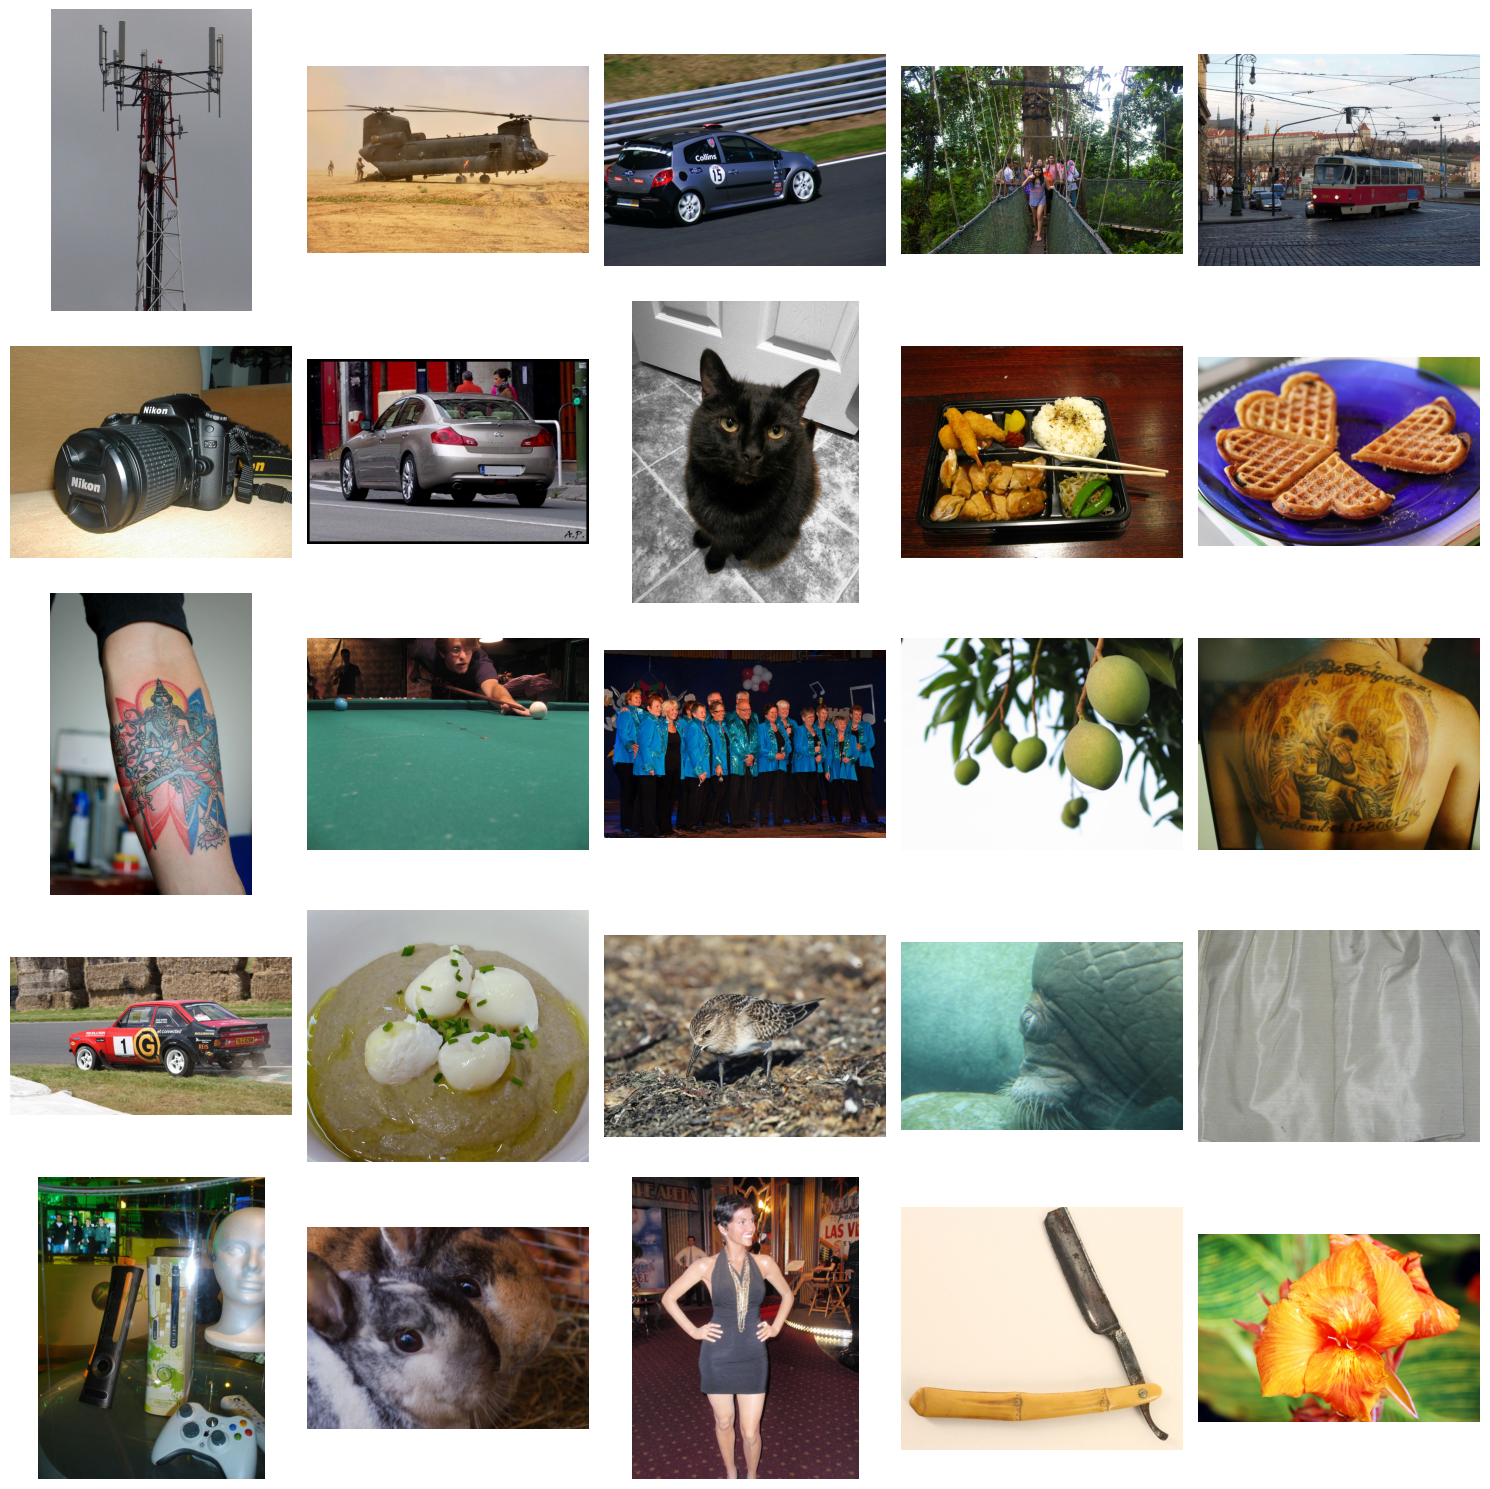

In [37]:
display_random_images(background_datasets[2])

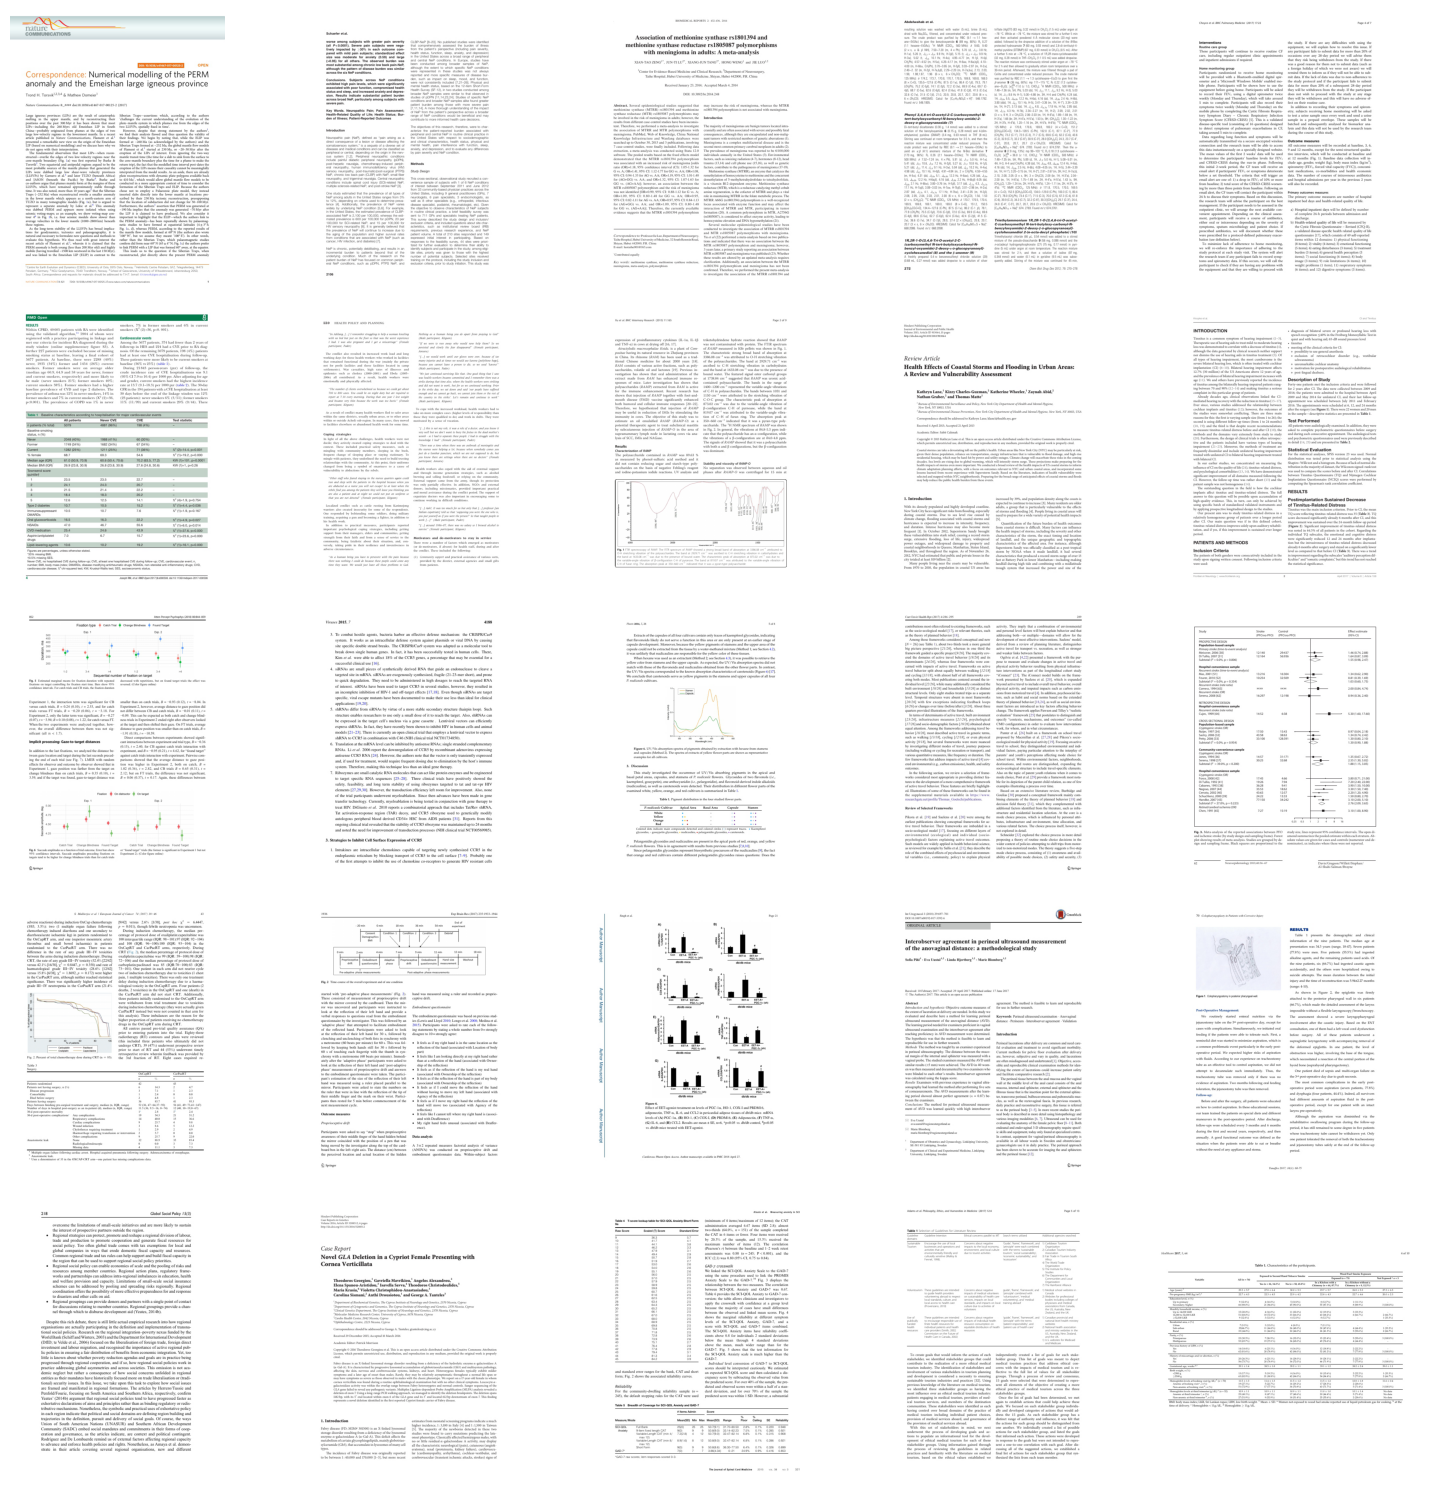

In [38]:
display_random_images(document_datasets[2])